In [1]:
import glob #to read the files
import json #to work if .json
import numpy as np #to math
import pandas as pd #to save the data
import math #to convertion calculus
from astropy.time import Time #to time converting
from astropy import units #time correction
from astropy.coordinates import SkyCoord #time correction
from scipy import interpolate #to interpolate the wavelength and flux
from tabulate import tabulate #to export in table format
from scipy.interpolate import interp1d
#import scipy.optimize as opt
from scipy import optimize
from scipy import signal
import os.path
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

def radec_to_xyz(ra, dec):
    x = math.cos(np.deg2rad(dec)) * math.cos(np.deg2rad(ra))
    y = math.cos(np.deg2rad(dec)) * math.sin(np.deg2rad(ra))
    z = math.sin(np.deg2rad(dec))

    return np.array([x, y, z], dtype=np.float64)

#functions from sncosmo
def cmb_dz(ra, dec):
    """See http://arxiv.org/pdf/astro-ph/9609034
     CMBcoordsRA = 167.98750000 # J2000 Lineweaver
     CMBcoordsDEC = -7.22000000
    """

    # J2000 coords from NED
    CMB_DZ = 371000. / 299792458.
    CMB_RA = 168.01190437
    CMB_DEC = -6.98296811
    CMB_XYZ = radec_to_xyz(CMB_RA, CMB_DEC)

    coords_xyz = radec_to_xyz(ra, dec)
    
    dz = CMB_DZ * np.dot(CMB_XYZ, coords_xyz)

    return dz

def cmb_to_helio(z, ra, dec):
    """Convert from CMB-frame redshift to heliocentric redshift.
    
    Parameters
    ----------
    z : float
        CMB-frame redshift.
    ra, dec: float
        RA and Declination in degrees (J2000).
    """

    dz = -cmb_dz(ra, dec)
    one_plus_z_pec = math.sqrt((1. + dz) / (1. - dz))
    one_plus_z_helio = (1. + z) * one_plus_z_pec

    return one_plus_z_helio - 1.


In [2]:
def one_lenght_redshift(u):
    
    redshift_value = None
    
    #if there is kind in the list continue
    if "kind" in data[url]["redshift"][0]:

        #if its heliocentric pick then
        if data[url]["redshift"][0]["kind"] == "heliocentric":

            redshift_value = float(data[url]["redshift"][0]["value"])
            print(redshift_value)
        
        #if its cmb pick then    
        if data[url]["redshift"][0]["kind"] == "cmb":

            #convertion of hours to degrees
            if data[url]["ra"][0]["u_value"] == "hours" and data[url]["dec"][0]["u_value"] == "degrees":

                c = SkyCoord(str(data[url]["ra"][0]["value"]),str(data[url]["dec"][0]["value"]), unit=(units.hourangle, units.deg))

            elif data[url]["ra"][0]["u_value"] == "hours" and data[url]["dec"][0]["u_value"] == "hours":

                c = SkyCoord(str(data[url]["ra"][0]["value"]),str(data[url]["dec"][0]["value"]), unit=(units.hourangle, units.hourangle))

            else:

                print("Erro!")

            redshift_value = float(cmb_to_helio(float(data[url]["redshift"][0]["value"]), c.ra.deg, c.dec.deg))
            print(redshift_value)
      
    #if there is only 1 and its not specificated
    else:
            
        redshift_value = float(data[url]["redshift"][0]["value"])
        print(redshift_value)
    
    return redshift_value

In [3]:
def redshift_selection(url):
    
    redshift_value = None
    
    for nredshift in range(0,len(data[url]["redshift"])):
            
        #if there is kind in the list continue
        if "kind" in data[url]["redshift"][nredshift]:

            #if its heliocentric pick then
            if data[url]["redshift"][nredshift]["kind"] == "heliocentric":

                redshift_value = float(data[url]["redshift"][nredshift]["value"])
                print(redshift_value)
                break
                
            
            #if its cmb 
            if data[url]["redshift"][nredshift]["kind"] == "cmb":

                #convertion of hours to degrees
                if data[url]["ra"][nredshift]["u_value"] == "hours" and data[url]["dec"][nredshift]["u_value"] == "degrees":

                    c = SkyCoord(str(data[url]["ra"][nredshift]["value"]),str(data[url]["dec"][nredshift]["value"]), unit=(units.hourangle, units.deg))

                elif data[url]["ra"][nredshift]["u_value"] == "hours" and data[url]["dec"][nredshift]["u_value"] == "hours":

                    c = SkyCoord(str(data[url]["ra"][nredshift]["value"]),str(data[url]["dec"][nredshift]["value"]), unit=(units.hourangle, units.hourangle))

                else:

                    print("Erro 1!")

                #convertion of cmb to heliocentric
                redshift_value = float(cmb_to_helio(float(data[url]["redshift"][nredshift]["value"]), c.ra.deg, c.dec.deg))
                print(redshift_value)
                break
            
    return redshift_value

In [4]:
def redshift_HB(url):
    redshift_value = None
    
    maxredshift = None
    
    sumredshift = 0
    HB_test = 0
    for nredshift in range(0,len(data[url]["redshift"])):
            
        #if not realize a sum to obtain a mean value
        if "kind" not in data[url]["redshift"][nredshift]:
            
            sumredshift = sumredshift + float(data[url]["redshift"][nredshift]["value"])
                
            #if the sn is in the hubnle flow realize a mean value of the redshifts
            if float(data[url]["redshift"][nredshift]["value"]) > 0.15:
                
                HB_test = 1
                
            #if not the first redshift is the max redshift
            if nredshift == 0:
                maxredshift = float(data[url]["redshift"][nredshift]["value"])
                
            if nredshift > 0 and maxredshift is not None:
                #then analise if the next redshift is grater than max redshift 
                if float(data[url]["redshift"][nredshift]["value"]) > maxredshift:
                        
                    maxredshift = float(data[url]["redshift"][nredshift]["value"])
        
    if HB_test == 1:
            
        #if sne is in the hubble flow realize a mean value
        redshift_value = sumredshift/len(data[url]["redshift"])
        print(redshift_value)  
    elif HB_test == 0:
            
        #if not the maximum redshift is the heliocentric redshift
        redshift_value = maxredshift
        print(redshift_value)
        
    return redshift_value

In [5]:
def redshift_value(url):
    redshift_func = None
    #if there is 1 value use it
    if len(data[url]["redshift"]) == 1:
        
        redshift_func = one_lenght_redshift(url)

    #if not...
    if len(data[url]["redshift"]) == 1 and redshift_func is None:
        
        print("redshift nao encontrado")
        
    if len(data[url]["redshift"]) > 1:
        
        redshift_func = redshift_selection(url)
                
    if len(data[url]["redshift"]) > 1 and redshift_func is None:
        redshift_func = redshift_HB(url)
        
    return redshift_func

In [6]:
def max_time(url):
   
    t0dat = data[url]["maxdate"][0]["value"]
    t0_max_photo = t0dat.split("/")
    t0_max_photo=str(t0_max_photo[0])+'-'+str(t0_max_photo[1])+'-'+str(t0_max_photo[2])
    t0_max_photo=Time(t0_max_photo).mjd
        
    return t0_max_photo
    

In [7]:
def suavization(x):
    
    b, a = signal.butter(8, 0.14)
    y = signal.filtfilt(b, a, x, padlen=0)
    
    return y

In [8]:
def gaussian(wavet, fluxt):
    
    final_flux = [[] for x in range(0,len(final_gradey))]
    
    kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e+1))
    
    spectra = [[] for x in range(0,len(final_gradey))]
    
    
    for l in range(0,len(wavet)):
        
        if len(wavet[l]) > 0:   
            
            interpolation = interp1d(wavet[l][0], fluxt[l][0])

            for j in range(0,len(final_gradey)):

                if min(wavet[l][0]) < final_gradey[j] < max(wavet[l][0]):

                    if interpolation(final_gradey[j]) > 0.001:
                        spectra[j].append([final_gradex[l],interpolation(final_gradey[j])])
    
    
    
    for l in range(0,len(spectra)):
        
        x = []
        y = []
        
        if len(spectra[l]) > 9:
            
            for j in range(0,len(spectra[l])):
                
                x.append([spectra[l][j][0]])
                y.append(spectra[l][j][1])
                
                
        if len(x) > 0:
            
            xidx = []
            for hh in range(0,len(x)):
                
                xidx.append(x[hh][0])
                
            X_ = np.linspace(min(xidx), max(xidx), max(xidx)-min(xidx) + 1)
            
            #print(X_)
            
            gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0).fit(x, y)
            
            y_mean= gp.predict(X_[:, np.newaxis])
        
        
        
            final_flux[l].append([X_, y_mean])
            
            
            
    return final_flux

In [15]:
sn_names=glob.glob("*.json")
#sn_names=["*.json"]
'''
file = open("newtraining.txt")
lines = file.readlines()
file.close()

sn_names = []

for line in lines:
    if line.startswith('#'): continue
    co=line.rstrip().replace('INDEF','Nan').split()
    sn_names.append(co[0])
'''

'\nfile = open("newtraining.txt")\nlines = file.readlines()\nfile.close()\n\nsn_names = []\n\nfor line in lines:\n    if line.startswith(\'#\'): continue\n    co=line.rstrip().replace(\'INDEF\',\'Nan\').split()\n    sn_names.append(co[0])\n'

In [16]:
len(sn_names)

823

In [17]:
#save_path = '/home/user/Área de Trabalho/salt2templates/data'

In [18]:
saltname="salt2_template_0.dat"

In [19]:
file = open(saltname)
lines = file.readlines()
file.close()

In [20]:
x_salt = []
y_salt = []
z_salt = []

#to separate the collumns
for line in lines:
    if line.startswith('#'): continue
    co=line.rstrip().replace('INDEF','Nan').split()
        
    #saving in temporary lists
    x_salt.append(co[0])
    y_salt.append(co[1])
    z_salt.append(co[2])

#to float
x_salt = np.array(x_salt, dtype=float)
y_salt = np.array(y_salt, dtype=float)
z_salt = np.array(z_salt, dtype=float)

In [21]:
maxv = []
for i in range(0, 71):
    
    maxv.append(z_salt[721*i + 500])

In [22]:
final_gradex = np.linspace(-20, 50, 71)
final_gradey = np.linspace(2000, 9200, 721)

list_data = [[]for y in range(0,len(final_gradey))]
number_data_density = [[[] for x in range(0,len(final_gradex))] for y in range(0,len(final_gradey))] 

for u in range(0,len(sn_names)):
    
    wave = [[] for x in range(0,len(final_gradex))]
    flux = [[] for x in range(0,len(final_gradex))]
    
    print(sn_names[u])

    #reading the .json file
    with open(sn_names[u], "r") as read_file:
        data = json.load(read_file)

    #catching the name of supernova
    url=sn_names[u]
    if url.endswith('.json'):
        url = url[:-5]
    #print(url)
    #defining the lists

    redshift = redshift_value(url)
        
    #print("valor final")    
    #print(redshift)
    
    
    spec_functions = []
    max_min = []
    
    t0 = max_time(url)
    if redshift is not None and t0 is not None:
        
        #spectra data
        i=0
        n=0
        while i < len(data[url]["spectra"]):


            if "time" in data[url]["spectra"][i]:

                spectratime = float(data[url]["spectra"][i]["time"]) - float(t0)
                #print(spectratime)

            alert3 = 0
            #if its the first spectra then previous time is the first time
            if i == 0:
                previoustime = spectratime

            else:
                #if the diference between the time and previous time is more than * days so emmit an alert to continue
                if (spectratime - previoustime) < 2000:

                    alert3 = 1
                    previoustime = spectratime

            #if the diference of time is less than * continue
            if alert3 == 1:

                #verifing if its calibrated and if it have a redshift correction 
                alert1 = 0 #for calibration
                alert2 = 0 #for redshift correction

                if data[url]["spectra"][i]["u_fluxes"] == "erg/s/cm^2/Angstrom":          
                    alert1 = 1 #first alert

                    if "deredshifted" in data[url]["spectra"][i]:
                        alert2 = 1 #second alert

                #if its calibrated and corrected
                if alert1 == 1 and alert2 == 1:

                    #there are 3 collumns: wavelength flux and flux error 
                    if len(data[url]["spectra"][i]["data"][0]) == 3:

                        n = n + 1

                    #there are 2 collumns: wavelength and flux
                    elif len(data[url]["spectra"][i]["data"][0]) == 2:

                        n = n + 1

                #if its calibrated, redshift not adjusted but with a clear redshift
                elif alert1 ==1 and alert2 == 0:   

                    #there are 3 collumns: wavelength flux and flux error 
                    if len(data[url]["spectra"][i]["data"][0]) == 3:

                        n = n + 1

                    #there are 2 collumns: wavelength and flux
                    elif len(data[url]["spectra"][i]["data"][0]) == 2:

                        n = n + 1

            i = i + 1

       
        
        if n > 9:
        

            #print(redshift)
            spectra_data = 0
            i=0
            n=0
            times = []
            max_fluxes = []
            time_verification = 0
            wavelength_verification = 0
            while i < len(data[url]["spectra"]):

                if "time" in data[url]["spectra"][i]:

                    spectratime = float(data[url]["spectra"][i]["time"]) - float(t0)
                    #print(spectratime)
                    #verifing if its calibrated and if it have a redshift correction 
                    alert1 = 0 #for calibration
                    alert2 = 0 #for redshift correction

                    if data[url]["spectra"][i]["u_fluxes"] == "erg/s/cm^2/Angstrom":          
                        alert1 = 1 #first alert

                        if "deredshifted" in data[url]["spectra"][i]:
                            alert2 = 1 #second alert

                    #if its calibrated and corrected
                    if alert1 == 1 and alert2 == 1:
                        #print("ok")
                        #there are 3 collumns: wavelength flux and flux error
                        if len(data[url]["spectra"][i]["data"][0]) == 3:

                            df = pd.DataFrame(data[url]["spectra"][i]["data"], columns=['wavelength', 'flux', 'fluxerror'])

                            #converting to float
                            df['wavelength'] = df['wavelength'].astype(float)
                            df['flux'] = df['flux'].astype(float)
                            
                            
                            #sort the data by wavelength
                            df = df.sort_values(by=['wavelength'])
                            df = df.reset_index(drop=True)

                            #to kill negative fluxes
                            fluxtemp = []
                            for var in range(0,len(df['flux'])):
                                if (df['flux'][var] > 0):
                                    fluxtemp.append(df['flux'][var])
                                else:
                                    fluxtemp.append(0)            
                 
                            #making a list of lists 
                            
                            suavf = suavization(fluxtemp)
                                               
                            for x in range(0,len(final_gradex)):
                                
                                if len(wave[x]) ==0:

                                    if final_gradex[x] - 0.5 < spectratime < final_gradex[x] + 0.5:

                                        wave[x].append(df['wavelength'])
                                        flux[x].append(suavf)  

                                
                        
                        
                        #there are 2 collumns: wavelength and flux
                        if len(data[url]["spectra"][i]["data"][0]) == 2:

                            df = pd.DataFrame(data[url]["spectra"][i]["data"], columns=['wavelength', 'flux'])

                            #converting to float
                            df['wavelength'] = df['wavelength'].astype(float)
                            df['flux'] = df['flux'].astype(float)
                            
                            
                            #sort the data by wavelength
                            df = df.sort_values(by=['wavelength'])
                            df = df.reset_index(drop=True)

                            #to kill negative fluxes
                            fluxtemp = []
                            for var in range(0,len(df['flux'])):
                                if (df['flux'][var] > 0):
                                    fluxtemp.append(df['flux'][var])
                                else:
                                    fluxtemp.append(0)            
              
                            #making a list of lists 
                            suavf = suavization(fluxtemp)

                            for x in range(0,len(final_gradex)):
                                
                                if len(wave[x]) ==0:

                                    if final_gradex[x] - 0.5 < spectratime < final_gradex[x] + 0.5:

                                        wave[x].append(df['wavelength'])
                                        flux[x].append(suavf)  
                      
       

                            
                    #if its calibrated, redshift not adjusted but with a clear redshift
                    if alert1 ==1 and alert2 == 0:   

                        #there are 3 collumns: wavelength flux and flux error 
                        if len(data[url]["spectra"][i]["data"][0]) == 3:

                            df = pd.DataFrame(data[url]["spectra"][i]["data"], columns=['wavelength', 'flux', 'fluxerror'])

                            #converting to float
                            df['wavelength'] = df['wavelength'].astype(float)
                            df['flux'] = df['flux'].astype(float)
                            
                            
                            #sort the data by wavelength
                            df = df.sort_values(by=['wavelength'])
                            df = df.reset_index(drop=True)

                            #to kill negative fluxes
                            fluxtemp = []
                            for var in range(0,len(df['flux'])):
                                if (df['flux'][var] > 0):
                                    fluxtemp.append(df['flux'][var])
                                else:
                                    fluxtemp.append(0)


                            #redshift correction
                            fluxtemp = [x * (((1+redshift))**3) for x in fluxtemp] #for the flux           
                            df['wavelength'] = [x * (1/(1+redshift)) for x in df['wavelength']] #for the wavelength
                            spectratime = spectratime/(1+redshift) #for time
                 
                            #making a list of lists 
                            suavf = suavization(fluxtemp)
                            
                            for x in range(0,len(final_gradex)):
                                
                                if len(wave[x]) ==0:

                                    if final_gradex[x] - 0.5 < spectratime < final_gradex[x] + 0.5:

                                        wave[x].append(df['wavelength'])
                                        flux[x].append(suavf)  

                             
                            
                            
                            
                        #there are 2 collumns: wavelength flux and flux error 
                        if len(data[url]["spectra"][i]["data"][0]) == 2:

                            df = pd.DataFrame(data[url]["spectra"][i]["data"], columns=['wavelength', 'flux'])

                            #converting to float
                            df['wavelength'] = df['wavelength'].astype(float)
                            df['flux'] = df['flux'].astype(float)
                            
                            
                            #sort the data by wavelength
                            df = df.sort_values(by=['wavelength'])
                            df = df.reset_index(drop=True)

                            #to kill negative fluxes
                            fluxtemp = []
                            for var in range(0,len(df['flux'])):
                                if (df['flux'][var] > 0):
                                    fluxtemp.append(df['flux'][var])
                                else:
                                    fluxtemp.append(0)

                            #redshift correction
                            fluxtemp = [x * (((1+redshift))**3) for x in fluxtemp] #for the flux           
                            df['wavelength'] = [x * (1/(1+redshift)) for x in df['wavelength']] #for the wavelength
                            spectratime = spectratime/(1+redshift) #for time
               
                            #making a list of lists 
                            suavf = suavization(fluxtemp)                       
                                                       
                            for x in range(0,len(final_gradex)):
                                
                                if len(wave[x]) ==0:

                                    if final_gradex[x] - 0.5 < spectratime < final_gradex[x] + 0.5:

                                        wave[x].append(df['wavelength'])
                                        flux[x].append(suavf)  
   
                        
                i = i + 1

    new_flux = [[] for x in range(0,len(final_gradex))]
    new_wave = [[] for x in range(0,len(final_gradex))]
    
    for k in range(0,len(wave)):

        if len(wave[k])>0:

            if min(wave[k][0]) < 6900 and max(wave[k][0]) > 7100:

                interpolation = interp1d(wave[k][0], flux[k][0])

                valor = maxv[k]/interpolation(7000)

                new_flux[k].append(flux[k][0]*valor)
                new_wave[k] = wave[k]
                
    flux = []
    wave = []
    
    gauss = gaussian(new_wave,new_flux)
    
    for k in range(0,len(gauss)):
        
        if len(gauss[k]) > 0:
            
            list_data[k].append(gauss[k])
    
    
    gauss = []

SN1990G.json
0.035781
SN1999Q.json
0.15333333333333335
SN2007at.json
0.0542
PTF10qwg.json
0.0679
SN2007on.json
0.006494
SN2005dh.json
0.01459
SN2002cx.json
0.02396
SN2002eb.json
0.027536
SN2000cm.json
redshift nao encontrado
SN2002bf.json
0.024197
SN2007jg.json
0.03712646456081914
SN2004bl.json
0.01732
SN1991bb.json
0.02656
SN2006ne.json
redshift nao encontrado
SN2006tv.json
0.37905
SN2006pr.json
0.1265
SN1991bd.json
0.01272
SN2007rj.json
redshift nao encontrado
SN1993C.json
0.01274
SN1996E.json
0.14333333333333334
SN1998aq.json
0.003699
SN2001G.json
0.01677
ESSENCEm138.json
0.29385
PTF10bjs.json
0.03006106322843971
SN2007ul.json
0.20666666666666667
SN2005P.json
0.00948
SN2016F.json
None
SN2002jw.json
0.17875
SN2008E.json
redshift nao encontrado
SN2014bg.json
0.036091
SN2017jdy.json
None
SN2013aj.json
0.009
SN1993ac.json
0.0556
SN2002iy.json
0.19566666666666666
LSQ14nr.json
0.091
SN2000cp.json
0.034204
SN2003it.json
0.025121
SN2007ob.json
0.0339
SN2002av.json
0.049041
SN2006tk.json
Non

0.01433
SN2007ap.json
0.015818
SN2008gp.json
0.033408756445185483
ESSENCEp527.json
None
SN2013bg.json
0.066
SN2013bx.json
0.12175
SN1960H.json
redshift nao encontrado
SN2018bhb.json
None
SN2008bq.json
0.03396129954823168
SN2003aa.json
None
SN2002hw.json
0.017535
SN2001cp.json
0.022402
SN2006py.json
0.05792995818508606
SN1999U.json
0.16666666666666666
SN1999ef.json
0.03914
SN2017hho.json
None
SN2003ez.json
None
SN2003eh.json
None
SN2007tg.json
None
SN2003gt.json
0.015657
SN1992ac.json
redshift nao encontrado
SN1997bq.json
0.0109
SN2013cs.json
0.009
SN2016A.json
None
SN2003du.json
0.006381
SN2001ck.json
0.034721
SN2018hpu.json
None
SN1956A.json
0.00559
SN1994D.json


0.00149
SN2002hu.json
0.036699
SN2007ax.json
0.006861
SN2009ag.json
0.00864
SN2018bfh.json
None
SN2004as.json
0.031021
PTF11dsb.json
0.19
SN2015bp.json
0.004069
SN2016cbx.json
None
SN2001ic.json
0.044241
PTF10nlg.json
0.0562
SN2009D.json
0.025007
SN1980N.json
0.005871
SN2005mc.json
0.02518235926807888
SN2018pc.json
None
SN2018epx.json
None
SN2003U.json
0.028341
SN1999ek.json
0.01752
SN2015bz.json
None
SN1999ee.json
0.01141
SN2005hj.json
0.05802511117307718
SN2005cc.json
redshift nao encontrado
SN2006le.json
0.017432
SN2006cm.json
0.016341
SN2011by.json
redshift nao encontrado
SN2001eh.json
0.037039
SN2006md.json
0.299
SN2007aj.json
0.011
SN2002gc.json
0.02131
SN2005na.json
0.02629016098230008
SN1999dg.json
0.022059
SN2002jr.json
0.14166666666666666
SN2009ab.json
0.01117
SN2007rh.json
0.1988
SN2006mk.json
0.2377
SN1998bn.json
0.005981
SN2008bf.json
0.024027
SN1998dk.json
0.01322
SN2002db.json
0.036218
SN2003ae.json
0.0329
SN2006fw.json
0.08302212937644482
SN2018fer.json
0.136
SN2003gn.j

redshift nao encontrado
ESSENCEp534.json
0.3101
SN2016itb.json
None
SN2007cp.json
0.036595
SN1964E.json
0.00554
LSQ12gpw.json
0.058
SN2014ac.json
0.0287
SN2007bz.json
0.021778
PTF11apk.json
0.0405
SN2015bq.json
0.028178
SN2006ob.json
0.059238
SN2011hk.json
0.017555
SN2002dk.json
0.01853
SN1999X.json
0.02517
SN2018jgn.json
None
SN2003lq.json
0.0243
SN2007bm.json
0.006211
SN2014J.json
0.000841
SN2001E.json
0.01926
SN2010hs.json
redshift nao encontrado
SN2012fv.json
0.028
SN2017mf.json
0.025678
SN2015cg.json
0.046
SN2017gwy.json
0.029871
SN1998cs.json
0.03256
SN2017hfv.json
None
SN2006eb.json
0.01723
PTF12giy.json
0.02885
SN1999C.json
0.026318
SN2016aqt.json
None
SN1939A.json
0.00312
SN2001ie.json
0.030738
SN2008L.json
0.0194
SN2006bh.json


0.010844139568583433
SN2001fe.json
0.013539
SN2003hx.json
0.007152
SN2005ej.json
0.037873
SN2013dh.json
0.013356
SN1999ac.json
0.0115
SN2006bk.json
0.0065
SN2002fk.json
0.007132
SN1957A.json
redshift nao encontrado
SN2001fh.json
0.01299
SN2001ei.json
0.0282
SN2016ffh.json
0.018204
SN2007kk.json


0.041045
SN2003iu.json
None
SN1998D.json
0.0123
SN2009ad.json
0.02834
SN2000cx.json
0.007929
SN1960R.json
0.002432
SN2001ec.json
0.045361
SN2007fc.json
0.033743
SN2001ex.json
0.02638
SN1998bu.json
0.002992
SN2007le.json
0.006721
SN2004S.json
0.00937
SN1998eb.json
0.01312
SN2005M.json
0.02197499768617539
SN2006ej.json
0.020458277727554597
SN2001ib.json
0.01931
SN1960F.json
0.00398
PTF11opu.json
0.0649
SN2001da.json
0.017195
SN2007H.json
0.0436
SN2003Y.json
0.01694
SN2006ef.json
0.017885190122076233
SN2012ih.json
0.01932
SN2001iq.json
0.01842
SN2007rx.json
0.0301
SN2008Y.json
0.0697
SN1990N.json
0.003399
SN1999by.json
0.002128
SN2006gt.json
0.044771
SN2003he.json
0.025504
SN2002jd.json
0.318
SN2016ah.json
None
SN1998dm.json
0.006541
SN2004go.json
0.02917
PTF11byi.json
0.0389
SN2000cu.json
0.023299
SN2003F.json
0.01724
SN2003kf.json
0.007388
SN2014aa.json
0.016982
SN1996X.json
0.00749
SN2003ep.json
redshift nao encontrado
SN2012he.json
0.056
SN2018hsy.json
None
SN2000dk.json
0.01744
SN200

SN2018btm.json
None
SN2005G.json
0.02314
SN2006br.json
0.02459
SN2001gc.json
0.01929
SN2006hb.json
0.0153328042114802
SN2008ee.json
0.0134
SN2006az.json
0.030935
SN2018hox.json
None
SN2014ah.json
0.021026
SN2008r3.json
0.0231
SN1997bp.json
0.008309
SN2005hk.json
0.01306
SN2004br.json
0.02316
PTF11gdh.json
0.02615
SN2006fy.json
0.08268
SN2001de.json
0.03106
SN2007ao.json
0.0247
SN2001bs.json
0.02919
SN2008ec.json
0.016317
SN1998ec.json
0.0199
SN2005kc.json
0.01512
SN1998dx.json
0.054221
SN1997dt.json
0.007318
SN2003ju.json
0.06833333333333333
SN1996ai.json
0.00316
SN2000ey.json
0.02041
SN2004L.json
0.032309
SN2008dt.json
0.03539
SN2007rs.json
0.1242
SN2006gz.json
None
SN2007gi.json
0.00482
SN2003ch.json
0.0304
SN2003ai.json
0.035001
SN2005bv.json
None
SN2018epa.json
0.0401
SN1999bv.json
0.01866
SN2008ha.json
0.004623
SN2003kc.json
0.03337
SN2003lf.json
0.41
SN2006fz.json
0.1047
SN2005W.json
0.008889
SN2018awn.json
None
SN2005el.json
0.01490009610926979
SN2002dp.json
0.011639
SN2001L.jso

In [23]:
list_data_temp = [[[] for x in range(0,len(final_gradex))] for y in range(0,len(final_gradey))]

In [24]:
 for i in range(0,len(list_data)):
    
    if len(list_data[i]) > 0:
        
        for j in range(0,len(list_data[i])):
            
            x = list_data[i][j][0][0]
            y = list_data[i][j][0][1]
            
            for k in range(0,len(x)):
                
                posx = [ii for ii,b in enumerate(final_gradex) if b == x[k]]
                        
                list_data_temp[i][posx[0]].append(y[k])

In [25]:
mean = [[[] for x in range(0,len(final_gradex))] for y in range(0,len(final_gradey))] 
std = [[[] for x in range(0,len(final_gradex))] for y in range(0,len(final_gradey))] 
N = [[[] for x in range(0,len(final_gradex))] for y in range(0,len(final_gradey))] 

for i in range(0,len(list_data_temp)):
    for j in range(0,len(list_data_temp[i])):
        #print(list_data_temp[i][j])
        
        
        
        if len(list_data_temp[i][j])>0:
            
            for k in range(0,len(list_data_temp[i][j])):
                N[i][j].append(1)
            
            mean[i][j].append(np.mean(list_data_temp[i][j]))
            std[i][j].append(np.std(list_data_temp[i][j]))
            
    

In [26]:
len(mean)

721

In [27]:
mean_s = [[[] for x in range(0,len(final_gradex))] for y in range(0,len(final_gradey))] 
std_s = [[[] for x in range(0,len(final_gradex))] for y in range(0,len(final_gradey))] 

In [28]:
for i in range(0,len(mean)):
    x = []
    zm = []
    sm = []
    for j in range(0,len(mean[i])):
        
        if len(mean[i][j])>0:
            
            x.append(final_gradex[j])
            zm.append(mean[i][j])
            sm.append(std[i][j])
            
    if len(x)>0:
        
        bm, am = signal.butter(8, 0.1)
        ym = signal.filtfilt(bm, am, zm, padlen=0)
        
        bd, ad = signal.butter(8, 0.3)
        yd = signal.filtfilt(bd, ad, sm, padlen=0)
        
    for k in range(0,len(x)):
        
        posx = [ii for ii,b in enumerate(final_gradex) if b == x[k]]
        
        
        mean_s[i][posx[0]].append(ym[k])
        std_s[i][posx[0]].append(yd[k])

In [29]:
xx_test = []
yy_test = []
mean_flux = []
std_flux = []

for i in range(0,len(mean_s)):
    
    for j in range(0,len(mean_s[i])):
        
        if len(mean_s[i][j]) > 0:
        
            yy_test.append(final_gradey[i])
            xx_test.append(final_gradex[j])
            mean_flux.append(mean_s[i][j][0][0])
            std_flux.append(std_s[i][j][0][0])
            

In [30]:
mean_flux[0]

0.018451361425964676

<IPython.core.display.Javascript object>


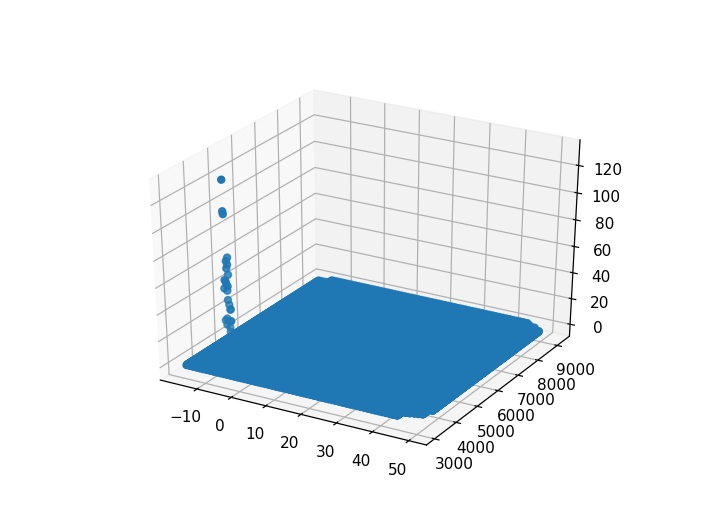

In [31]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xx_test, yy_test, std_flux)
#ax.set_zlim3d(0,0.1e-12)

plt.show()

In [32]:
x_grid = np.linspace(-10, 50, 61)
y_grid = np.linspace(3500, 9200, 600)
B1, B2 = np.meshgrid(x_grid, y_grid, indexing='xy')

<IPython.core.display.Javascript object>


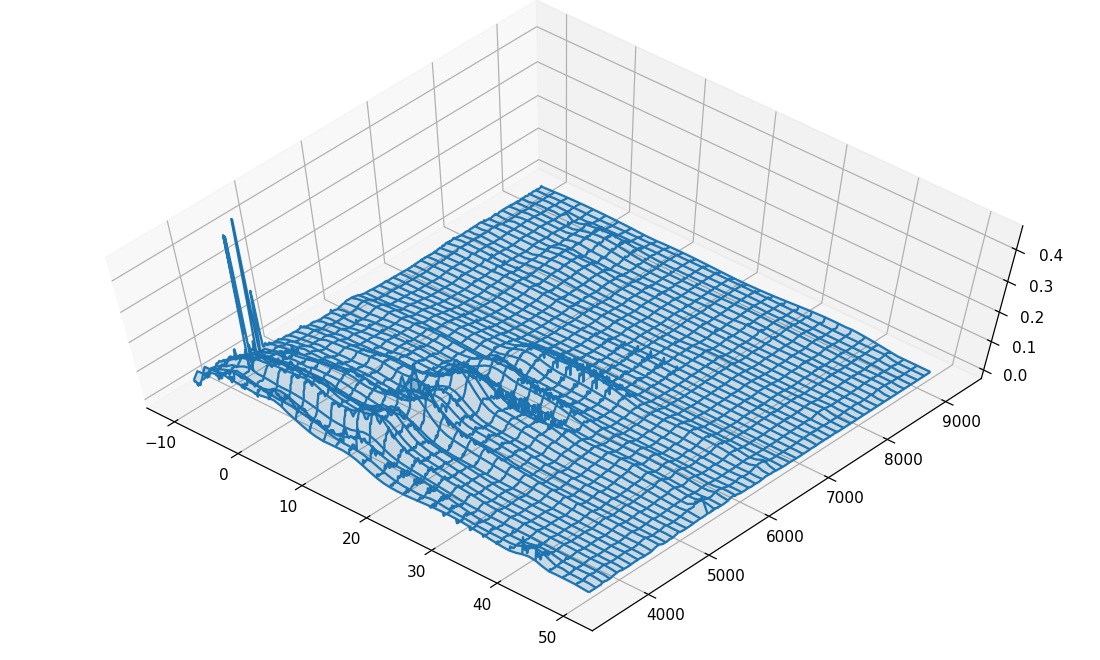

In [34]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import scipy.interpolate as interp
Z = interp.griddata((xx_test,yy_test),std_flux,(B1,B2),method='cubic',fill_value = 0,rescale=True)
#Z = splinemean(B1, B2)
%matplotlib notebook
fig = plt.figure(figsize=(10,6))
ax = axes3d.Axes3D(fig)
ax.plot_wireframe(B1, B2, Z)
ax.plot_surface(B1, B2, Z,alpha=0.2)
#ax.scatter3D(xx_test,yy_test,mean_flux, c='r')

plt.show()

In [30]:
density_x = []
density_y = []
density_z = []

for i in range(0,len(final_gradex)):
    for j in range(0,len(final_gradey)):
        
        density_x.append(final_gradex[i])
        density_y.append(final_gradey[j])
        density_z.append(sum(N[j][i]))
        
        

In [31]:
for i in range(0,len(density_z)):
    
    if density_z[i] != 0:
        
        print(density_z[i])

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


4
4
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
4
4
4
3
4
4
4
4
5
7
6
8
9
11
12
12
12
13
13
13
13
13
13
13
13
13
13
13
13
13
13
14
15
15
20
20
22
24
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
2

9
9
9
9
9
9
9
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
7
7
7
7
7
7
6
7
7
6
6
6
6
6
6
5
5
5
5
5
5
5
5
5
5
5
4
4
4
4
4
4
4
4
4
3
3
3
3
3
3
3
3
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
4
5
6
5
7
7
9
11
13
16
16
20
23
27
28
28
28
29
30
30
30
31
32
32
32
32
33
32
34
36
37
38
39
39
44
46
49
54
59
60
60
60
60
60
61
61
61
60
62
62
62
62
62
62
62
62
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64


77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
77
76
76
76
76
75
75
73
73
72
70
69
68
67
64
62
61
59
57
55
47
47
47
47
44
41
37
36
33
33
33
32
29
27
26
25
23
20
16
14
13
12
12
12
12
12
12
12
12
12
12
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
10
10
10
10
10
10
9
10
10
9
9
9
9
8
8
6
6
6
6
6
6
6
6
6
6
6
5
5
5
4
4
4
4
4
4
3
3
3
3
3
3
3
3
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
4
5
6
5
7
7
10
13
16
19
21
25
29
33
34
35
35
36
37
37
37
38
38
38
39
39
40
39
42
45
46
48
52
52
57
60
64
69
74
75
7

85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
84
84
84
84
83
83
81
81
80
77
76
74
73
69
67
66
63
61
59
51
51
51
51
48
45
41
40
37
37
36
34
31
28
27
26
24
21
17
15
14
13
13
12
12
12
12
12
12
12
12
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
10
10
10
10
10
10
9
10
10
9
9
9
9
8
8
6
6
6
6
6
6
6
6
6
6
6
5
5
5
4
4
4
4
4
4
3
3
3
3
3
3
3
3
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
4
5
6
5
7
7
10
13
16
20
22
26
30
34
35
36
35
3

39
39
40
40
41
40
43
46
47
49
53
53
59
63
68
74
79
80
80
80
80
80
81
81
81
80
82
82
82
82
82
82
82
82
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
84
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
8

83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
83
82
82
82
82
81
81
80
80
79
77
76
74
73
68
66
65
63
61
59
51
51
51
51
48
45
41
40
37
37
36
35
30
28
27
26
24
21
17
15
14
13
13
12
12
12
12
12
12
12
12
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
10
10
10
10
10
10
9
10
10
9
9
9
9
8
8
6
6
6
6
6
6
6
6
6
6
6
5
5
5
4
4
4
4
4
4
3
3
3
3
3
3
3
3
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
4
5
6
5

69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
69
69
68
68
67
65
64
62
61
58
56
55
53
52
51
45
45
45
45
43
41
37
36
34
34
33
3

51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
51
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
52
51
51
50
50
49
49
49
47
46
44
42
42
41
41
41
39
39
39
39
38
36
32
31
30
30
29
27
23
2

34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
33
33
33
33
33
32
32
32
32
32
32
32
31
31
30
28
28
27
27
27
26
26
26
26
26
23
22
22
21
21
20
18
16
16
16
15
13
11
9
8
8
8
8
7
7
7
7
7
7
7
7
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
5
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
5
5
5
5
5
5
4
5
5
4
4

In [32]:
len(density_z)

51191

<IPython.core.display.Javascript object>


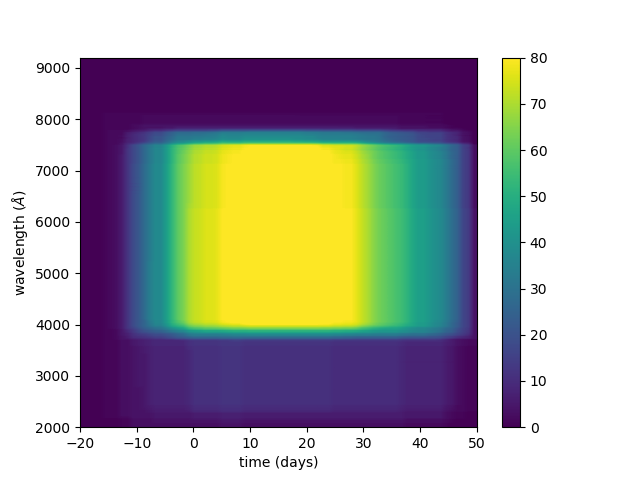

In [33]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib notebook
z = np.reshape(density_z, (71, 721)).T
plt.imshow(z, extent=(np.amin(density_x), np.amax(density_x), np.amin(density_y), np.amax(density_y)), cmap=cm.viridis, aspect='auto', interpolation = 'bilinear')
plt.colorbar()
plt.clim(0,80)
plt.xlabel('time (days)')
plt.ylabel('wavelength ($\AA$)')
plt.savefig('densityplot.png')
plt.show()

In [34]:
import os.path 

save_path = '/home/user/Área de Trabalho/mathematica_analisys'

table = []
for k in range(0,len(mean_flux)):
    table.append((xx_test[k], yy_test[k], mean_flux[k]))


name_of_file = 'M0'

completeName = os.path.join(save_path, name_of_file+".dat")      
    
    
f = open(completeName, 'w')
f.write(tabulate(table, tablefmt="plain"))
f.close()
